# Cross-Language Integration
The Wolfram Language has built-in support for various `external evaluators`, as long as they have ZMQ and JSON packages installed.  
We'll look into making python and julia external calls

## Julia Language
First, we check whether or not the Wolfram Language 'knows' of an existing julia binary.

Dataset[<|a1777dad-18a3-452c-9605-b709859d1d1f -> 
 
>     <|System -> Julia, Version -> 1.6.01, 
 
>      Target :> /home/george/SoftwareHub/15.julia-1.6.0-beta1/bin/julia, 
 
>      Executable :> /home/george/SoftwareHub/15.julia-1.6.0-beta1/bin/julia, 
 
>      Registered -> True|>|>, TypeSystem`Assoc[TypeSystem`Atom[String], 
 
>    TypeSystem`Struct[{System, Version, Target, Executable, Registered}, 
 
>     {TypeSystem`Atom[String], TypeSystem`Atom[String], TypeSystem`Atom[String], 
 
>      TypeSystem`Atom[String], TypeSystem`Atom[TypeSystem`Boolean]}], 1], 
 
>   <|HiddenItems -> {Executable}|>]
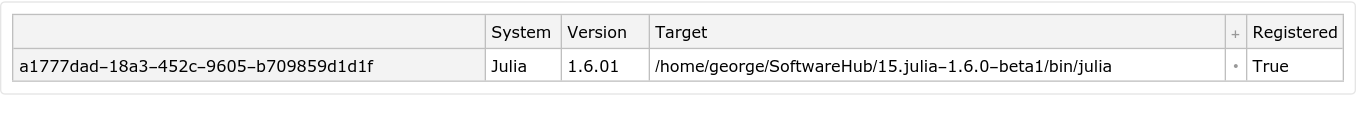

In [1]:
FindExternalEvaluators["Julia"]

<div class="alert alert-block alert-warning">
<b>Note:</b>
If you're running this on the binder, the above should return the following target: `/srv/julia/bin/julia`. If you're running this locally and the above returns an empty `Dataset`, then we must instruct the Wolfram Language where to look for a binary. We can do this by searching and registering our executable, e.g. on Unix OS by running `which julia` on the command line and then running the following cell:
</div>

In [9]:
(*
RegisterExternalEvaluator["Julia", "/executable/result/from/which/julia"]
*)

### Single Commands
We can use `ExternalEvaluate` to evaluate commands in the registered evaluator and return the result as a Wolfram Language expression. For example, Julia dictionaries get returned as an `Association`

In [1]:
ExternalEvaluate["Julia","Dict(\"one\" => 1, \"two\" => 2, \"three\" => 3)"]

<|two -> 2, one -> 1, three -> 3|>

<div class="alert alert-block alert-warning">
<b>Note:</b>
If you're running this locally and the above returns an error, you probably need to add the following packages, by running the following on the julia REPL:
</div>

```julia
using Pkg
Pkg.add("ZMQ")
Pkg.add("JSON")
Pkg.add("LinearAlgebra")
```

We can pass in-line template arguments using the following syntax:

In [2]:
var=1;
ExternalEvaluate["Julia","Dict(\"one\" => <*var*>, \"two\" => 2, \"three\" => 3)"]

<|two -> 2, one -> 1, three -> 3|>

We can run some code before running the command, e.g. import some packages:

In [6]:
ExternalEvaluate[{"Julia", "Prolog" -> "using LinearAlgebra"},
 "A = [1 1 1 1; 2 2 2 2; 3 3 3 3; 4 4 4 4];
  Bidiagonal(A, :U)"]

{{1, 1, 0, 0}, {0, 2, 2, 0}, {0, 0, 3, 3}, {0, 0, 0, 4}}

### Interactive usage
We can spin up a persistent session with `StartExternalSession` and exchange data b/w the two processes:

ExternalSessionObject[10d2c027-b806-4a55-8424-a40b4603e2fe]
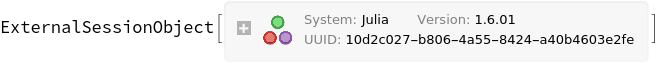

In [97]:
juliaSession = StartExternalSession["Julia"]

In [98]:
ExternalEvaluate[juliaSession,"
function f(x,y)
  x + y
 end"];
 ExternalEvaluate[juliaSession,"f(2,2)"]

4

We can then call julia from within WolframLanguage functions:

In [100]:
juliaCubicRoot[x_]:= ExternalEvaluate[juliaSession, StringTemplate["cbrt(`1`)"][x]]
juliaCubicRoot[4]

1.5874

A slightly more convenient form would be to use `ExternalFunction`:

In [1]:
juliaCbrt=ExternalFunction["Julia", "cbrt"];
juliaCbrt[4]

1.5874

-Graphics-
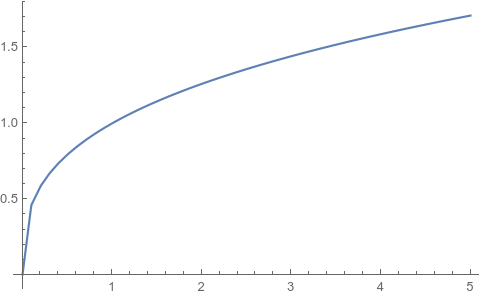

In [3]:
Plot[juliaCbrt[x], {x, 0, 5}, MaxRecursion -> 0, PlotPoints -> 50]

We can end a session using `DeleteObject`:

In [36]:
DeleteObject[juliaSession]

## Python
Similarly, we can start a python session:

NumericArray[<10,3>, Real64]
{{0.0123855, 0.860742, 0.70565}, {0.56539, 0.892046, 0.750713}, 
 
>   {0.757005, 0.0415251, 0.948603}, {0.501411, 0.0234982, 0.86683}, 
 
>   {0.164452, 0.455701, 0.995048}, {0.299957, 0.121807, 0.779473}, 
 
>   {0.773816, 0.687292, 0.310148}, {0.138573, 0.133189, 0.220941}, 
 
>   {0.853866, 0.495135, 0.16122}, {0.975491, 0.164465, 0.138137}}
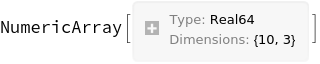
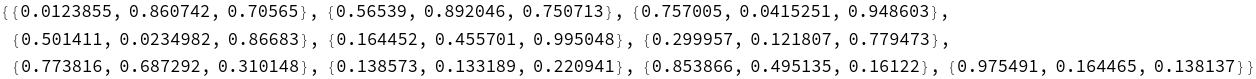

In [9]:
ExternalEvaluate[{"Python", "Prolog" -> "import numpy as np"}, "np.random.rand(10,3)"]
%//Normal

Note dense data formats like ndarrays get returned as efficient `NumericArray` expressions.

### Python's wolframclient library
In python, this interaction can be two-way using the [wolframclient package](https://reference.wolfram.com/language/WolframClientForPython/)

In [59]:
pySession = StartExternalSession["Python"];
ExternalEvaluate[pySession,"
from wolframclient.evaluation import WolframLanguageSession\n
from wolframclient.language import wl, wlexpr\n
wlSession = WolframLanguageSession()
"]

In [61]:
ExternalEvaluate[pySession,"
wlexpr('Range[5]')
"]

{1, 2, 3, 4, 5}

x   Sin[2 x]
- - --------
2      4
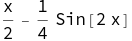

In [62]:
ExternalEvaluate[pySession,"
wlSession.evaluate(wlexpr('Integrate[Sin[x]^2,x]'))
"]

In [63]:
ExternalEvaluate[pySession,"
from wolframclient.language import Global\n
wlSession.evaluate(wlexpr('function[x_, f_] := f[x]'))
"]
ExternalEvaluate[pySession,"
wlSession.evaluate(Global.function(4.,wl.Sin))
"]

-0.756802